In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('crop_yield_train.csv')
df.head()

,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,Jharkhand,RAMGARH,Potato,2013,Winter,1361.0,7544.0,5.54
1,Jammu and Kashmir,REASI,Moong(Green Gram),2015,Kharif,13.0,9.0,0.70
2,Haryana,GURGAON,Sweet potato,2009,Whole Year,39.0,800.0,20.51
3,Uttar Pradesh,JALAUN,Sannhamp,2010,Kharif,9.0,3.0,0.33
4,Tamil Nadu,MADURAI,Sugarcane,2006,Whole Year,6006.0,656204.0,109.26


In [3]:
df.dropna(inplace = True)
df.isna().sum()

State         0
District      0
Crop          0
Crop_Year     0
Season        0
Area          0
Production    0
Yield         0
dtype: int64

In [4]:
df.columns = df.columns.str.strip()
df[['State', 'District', 'Crop', 'Season']] = df[['State', 'District', 'Crop', 'Season']].apply(lambda x: x.str.strip().str.title())

In [5]:
q1 = df['Area'].quantile(0.25)
q3 = df['Area'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Area'] < lower_bound) | (df['Area'] > upper_bound)]
print("Number of outliers:", len(outliers))

Number of outliers: 45157


In [6]:
df['Area'] = df['Area'].clip(lower_bound, upper_bound)

In [7]:
q1 = df['Production'].quantile(0.25)
q3 = df['Production'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Production'] < lower_bound) | (df['Production'] > upper_bound)]
print("Number of outliers:", len(outliers))

Number of outliers: 47985


In [8]:
df['Production'] = df['Production'].clip(lower_bound, upper_bound)

In [9]:
q1 = df['Yield'].quantile(0.25)
q3 = df['Yield'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['Yield'] < lower_bound) | (df['Yield'] > upper_bound)]
print("Number of outliers:", len(outliers))

Number of outliers: 41104


In [10]:
df['Yield'] = df['Yield'].clip(lower_bound, upper_bound)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(df[['Area', 'Production', 'Yield']])

array([[1.29441008e-01, 4.22763316e-01, 1.00000000e+00],
       [1.23545264e-03, 5.04357085e-04, 1.29749768e-01],
       [3.70826008e-03, 4.48317409e-02, 1.00000000e+00],
       ...,
       [5.69790948e-01, 1.00000000e+00, 1.00000000e+00],
       [5.99085156e-03, 7.84555465e-04, 4.07784986e-02],
       [2.65341749e-02, 6.33248340e-03, 7.59962929e-02]],
      shape=(272298, 3))

In [14]:
target = 'Yield'
categorical_features = ['State', 'District', 'Crop', 'Season']

In [16]:
X = df[['State', 'District', 'Crop', 'Crop_Year', 'Season', 'Area', 'Production']]
y = df['Yield']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_encoded = X.copy()
X_encoded = X.copy()
for col in categorical_features:
    X_encoded[col] = X[col].astype('category').cat.codes
    X_encoded[col] = X[col].astype('category').cat.codes

In [19]:
X_encoded

,State,District,Crop,Crop_Year,Season,Area,Production
0,15,532,38,2013,5,1361.0,7544.0
1,14,540,27,2015,1,13.0,9.0
2,12,231,49,2009,4,39.0,800.0
3,34,264,43,2010,1,9.0,3.0
4,30,391,47,2006,4,6006.0,17844.5
...,...,...,...,...,...,...,...
276262,14,36,38,2014,1,17.0,75.0
276263,16,203,8,2018,1,13.0,7.0
276264,30,649,9,2002,4,5991.0,17844.5
276265,16,124,29,2017,1,63.0,14.0


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_scaled = X_encoded.copy()
X_scaled = X_encoded.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

In [21]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
catboost_model = CatBoostRegressor(verbose=0, random_state=42)

catboost_model.fit(X, y, cat_features=categorical_features)

In [25]:
y_pred_cat = catboost_model.predict(X_test)
cat_rmse = mean_squared_error(y_test, y_pred_cat)
r2_score(y_test, y_pred_cat)

0.9857214042494539

In [26]:
import joblib

joblib.dump(catboost_model, 'catboost_yield_model2.pkl')

['catboost_yield_model2.pkl']

In [27]:
import joblib
import pandas as pd

model = joblib.load('catboost_yield_model2.pkl')
label_encoders = joblib.load('label_encoders.pkl')

input_data = {
    'State': ['Punjab'],
    'District': ['Ludhiana'],
    'Crop': ['Wheat'],
    'Crop_Year': [2024],
    'Season': ['Rabi'],
    'Area': [1200],
    'Production' : [2035] }

input_df = pd.DataFrame(input_data)

for col in ['State', 'District', 'Crop', 'Season']:
    input_df[col] = label_encoders[col].transform(input_df[col])

# Predict yield
predicted_yield = model.predict(input_df)[0]
print(f"Predicted Yield: {predicted_yield:.2f} tons/hectare")
print(f"Production is {predicted_yield * input_data['Area'][0]}")

Predicted Yield: 1.22 tons/hectare
Production is 1464.4797763118975


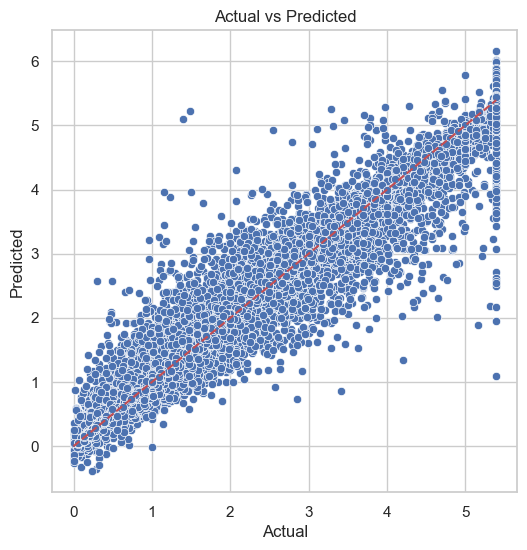

In [28]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_cat)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.grid(True)
plt.show()


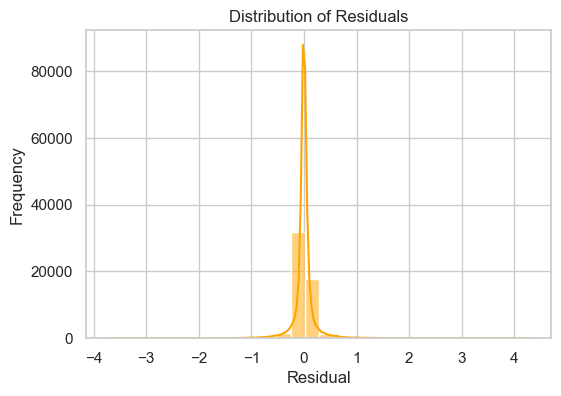

In [29]:
residuals = y_test - y_pred_cat

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


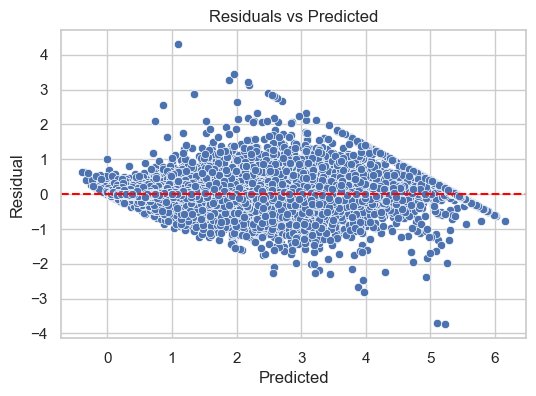

In [30]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_cat, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.grid(True)
plt.show()
